<center><h1>CNN + AE - Escenario experimental 1</header1></center>



## Importación de librerias necesarias

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Cargar el Dataset

In [2]:
datapath = 'https://raw.githubusercontent.com/hfcatucuamba/proyectoInternetworking/main/Escenario1.csv'
dataframe = pd.read_csv(datapath,low_memory=False, sep=';')

In [3]:
#Visualización de los 5 primeros datos
dataframe.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,10.0.2.15,53913,216.58.208.46,80,6,435,0,45.977.011.494.253,435,0,...,0,0,0,0,0,0,0,0,0,nonTOR
1,10.0.2.15,53913,216.58.208.46,80,6,259,0,77.220.077.220.077,259,0,...,0,0,0,0,0,0,0,0,0,nonTOR
2,10.0.2.15,53913,216.58.208.46,80,6,891,0,22.446.689.113.356,891,0,...,0,0,0,0,0,0,0,0,0,nonTOR
3,10.0.2.15,53913,216.58.208.46,80,6,1074,0,18.621.973.929.237,1074,0,...,0,0,0,0,0,0,0,0,0,nonTOR
4,10.0.2.15,53913,216.58.208.46,80,6,315,0,63.492.063.492.064,315,0,...,0,0,0,0,0,0,0,0,0,nonTOR


# Normalización de los datos

In [4]:
# Normalización de los datos
def dfNormalize(df):
    for feature_name in df.columns:
        df.loc[:,feature_name]= pd.to_numeric(df.loc[:,feature_name], errors='coerce').fillna(0)
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()   
        if (max_value - min_value) > 0:
            df.loc[:,feature_name] = (df.loc[:,feature_name] - min_value) / (max_value - min_value)
        else:
            df.loc[:,feature_name] = (df.loc[:,feature_name]- min_value)    
    return df

In [5]:
#Muestra el tamaño del dataframe (número de filas y columnas)
print (dataframe.shape)
dataframe = dataframe.reindex(np.random.permutation(dataframe.index)).copy()
print(dataframe.describe())
print (list(dataframe))

(7000, 29)
        Source Port   Destination Port   Protocol   Flow Duration  \
count   7000.000000        7000.000000     7000.0    7.000000e+03   
mean   42153.076571        7647.390714        6.0    4.002204e+06   
std    17081.978193       17168.713987        0.0    4.450485e+06   
min       80.000000          21.000000        6.0    1.700000e+01   
25%    38894.000000         443.000000        6.0    2.013598e+05   
50%    45337.000000         443.000000        6.0    4.409195e+05   
75%    54698.000000         443.000000        6.0    9.829612e+06   
max    61156.000000       65514.000000        6.0    1.000000e+07   

        Flow IAT Max   Flow IAT Min   Fwd IAT Max   Fwd IAT Min   Bwd IAT Max  \
count   7.000000e+03   7.000000e+03  7.000000e+03  7.000000e+03  7.000000e+03   
mean    1.148187e+06   1.023332e+05  1.079414e+06  1.035305e+05  8.884348e+05   
std     2.113319e+06   4.321051e+05  2.135818e+06  6.952060e+05  1.933856e+06   
min     1.700000e+01  -4.340000e+02  0.0000

In [6]:
#Obtiene las claves del dataframe (los nombres de las columnas)
keys = dataframe.keys()
data_to_process = dataframe[keys[4:len(keys) - 1]].copy()
x_normalised = dfNormalize(data_to_process)
print(x_normalised.describe())

        Protocol   Flow Duration   Flow Bytes/s   Flow Packets/s  \
count     7000.0     7000.000000    7000.000000      7000.000000   
mean         0.0        0.400219       0.000143         0.000167   
std          0.0        0.445049       0.011952         0.012051   
min          0.0        0.000000       0.000000         0.000000   
25%          0.0        0.020134       0.000000         0.000000   
50%          0.0        0.044090       0.000000         0.000000   
75%          0.0        0.982961       0.000000         0.000000   
max          0.0        1.000000       1.000000         1.000000   

        Flow IAT Mean   Flow IAT Std   Flow IAT Max   Flow IAT Min  \
count     7000.000000         7000.0    7000.000000    7000.000000   
mean         0.017407            0.0       0.114853       0.010376   
std          0.055836            0.0       0.211398       0.043627   
min          0.000000            0.0       0.000000       0.000000   
25%          0.000000            0.0 

In [7]:
#Cambiar las etiquetas de los datos de ‘nonTOR’ y ‘TOR’ a 1 y 0 respectivamente.
change_labels = lambda x: 1 if x == 'nonTOR' else 0

In [8]:
#crea una nueva variable llamada y_normalised que contiene los valores de la columna 
#‘label’ del dataframe original después de aplicar la función change_labels.
y_normalised = dataframe['label'].apply(change_labels)

In [9]:
# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x_normalised, y_normalised, test_size=0.3, random_state=42)

# Creación del modelo

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.layers import Reshape, UpSampling1D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping

# Encoder
model = Sequential([
    Conv1D(64, 3, input_shape=(X_train.shape[1], 1), padding="same", activation="relu", kernel_constraint=MaxNorm(3)),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(32, 3, padding="same", activation="relu", kernel_constraint=MaxNorm(3)),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(16, 3, padding="same", activation="relu", kernel_constraint=MaxNorm(3)),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(1, activation="sigmoid"),
])


model.compile(optimizer="adam",
              loss="binary_crossentropy", 
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 32)             0

In [11]:
batch_size = 32
steps_per_epoch = (X_train.shape[0]//batch_size)
validation_steps = (x_normalised.shape[0] // batch_size)

es = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=200)

In [12]:
%%time 

# Entrenar el modelo
model.fit(X_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 35,
    validation_data=(X_test, y_test),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

Epoch 1/35
153/153 [==============================] - 7s 33ms/step - loss: 0.4780 - accuracy: 0.8137 - val_loss: 0.2960 - val_accuracy: 0.9105
Epoch 2/35
153/153 [==============================] - 1s 8ms/step - loss: 0.2402 - accuracy: 0.9178
Epoch 3/35
153/153 [==============================] - 1s 9ms/step - loss: 0.1744 - accuracy: 0.9384
Epoch 4/35
153/153 [==============================] - 1s 9ms/step - loss: 0.1449 - accuracy: 0.9571
Epoch 5/35
153/153 [==============================] - 1s 9ms/step - loss: 0.1310 - accuracy: 0.9620
Epoch 6/35
153/153 [==============================] - 2s 11ms/step - loss: 0.0986 - accuracy: 0.9745
Epoch 7/35
153/153 [==============================] - 1s 9ms/step - loss: 0.0916 - accuracy: 0.9766
Epoch 8/35
153/153 [==============================] - 1s 8ms/step - loss: 0.0857 - accuracy: 0.9793
Epoch 9/35
153/153 [==============================] - 2s 11ms/step - loss: 0.0821 - accuracy: 0.9795
Epoch 10/35
153/153 [==============================] - 

In [13]:
loss, accuracy = model.evaluate(X_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

66/66 [==============================] - 0s 5ms/step - loss: 0.0538 - accuracy: 0.9871
test_loss: 5.38
test_accuracy: 98.71


In [14]:
from sklearn.metrics import classification_report

# Hacer predicciones sobre los datos de prueba
y_pred = model.predict(X_test)

# Convertir las probabilidades en etiquetas binarias (0 o 1) usando un umbral de 0.5
y_pred_binary = (y_pred > 0.5).astype(int)

# calcular métricas de evaluación
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred_binary)*100
f1 = f1_score(y_test, y_pred_binary, average='weighted')*100
prec = precision_score(y_test, y_pred_binary, average='weighted')*100
rec = recall_score(y_test, y_pred_binary, average='weighted')*100

# imprimir las métricas
print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", prec)
print("Recall:", rec)

66/66 [==============================] - 1s 4ms/step
Accuracy: 98.71428571428571
F1 score: 98.714410818065
Precision: 98.72210242587602
Recall: 98.71428571428571


## Grafico Roc Curve

66/66 [==============================] - 0s 4ms/step


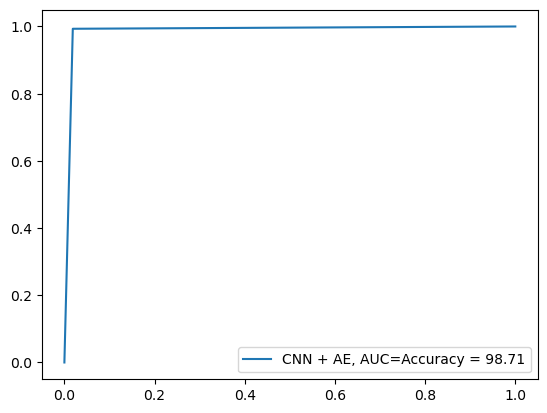

In [15]:
import matplotlib.pyplot as plt
from sklearn import metrics
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
CNN = "Accuracy = {:.2f}".format(accuracy*100)
plt.plot(fpr, tpr, label="CNN + AE, AUC=" + str(CNN))
plt.legend()